In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [8]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [9]:
from pymono.cnn_func import ResNet10

In [10]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [12]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [13]:
crystal = os.path.join(data_dir,"CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX")

In [14]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX'

# CsI_4x4_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 4x4 SiPMs, thus 12x12 matrix
- 50 k photons per point (CsI, with ~100 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- new data format (x,y,z)

### CNN comparisons: 
- Adapt basic, 3x3 and resnet to 12 x 12

## Setup

In [15]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]))

In [16]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


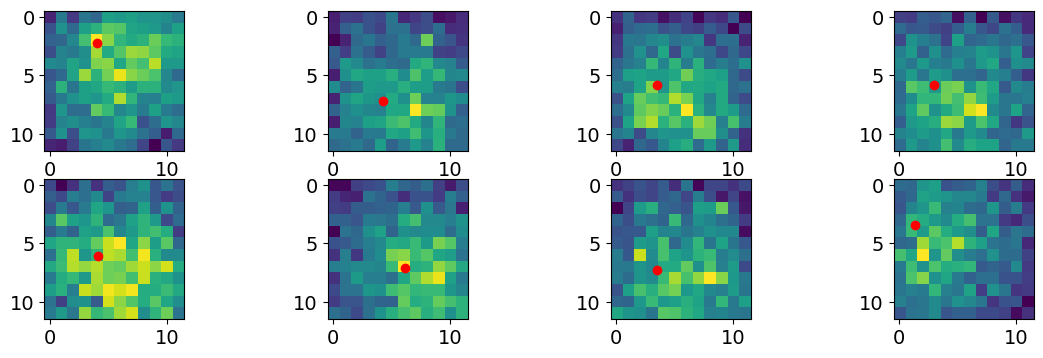

In [17]:
plot_images(imgs, mdata, range(0,8))

In [18]:
imgs[0]

array([[34., 54., 38., 53., 49., 65., 63., 65., 62., 62., 60., 55.],
       [44., 61., 50., 65., 70., 77., 76., 66., 65., 63., 57., 65.],
       [48., 49., 58., 74., 94., 82., 71., 68., 70., 79., 72., 70.],
       [43., 57., 54., 60., 85., 68., 76., 84., 83., 77., 68., 66.],
       [59., 57., 66., 61., 81., 82., 67., 78., 74., 87., 63., 63.],
       [45., 50., 66., 84., 70., 80., 92., 82., 79., 75., 58., 50.],
       [48., 70., 53., 65., 67., 72., 70., 64., 70., 70., 59., 62.],
       [46., 54., 61., 65., 62., 68., 86., 71., 57., 56., 65., 63.],
       [38., 62., 51., 51., 78., 72., 58., 62., 55., 65., 55., 51.],
       [39., 57., 60., 56., 53., 57., 66., 72., 44., 51., 62., 58.],
       [46., 61., 43., 62., 61., 54., 62., 59., 52., 47., 32., 50.],
       [34., 32., 40., 53., 56., 59., 54., 51., 41., 27., 45., 38.]],
      dtype=float32)

In [19]:
np.mean(imgs[0])

61.11111

In [20]:
np.std(imgs[0])

12.989906

In [21]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


In [22]:
energy

array([8764., 8913., 8846., ..., 8615., 8792., 8880.], dtype=float32)

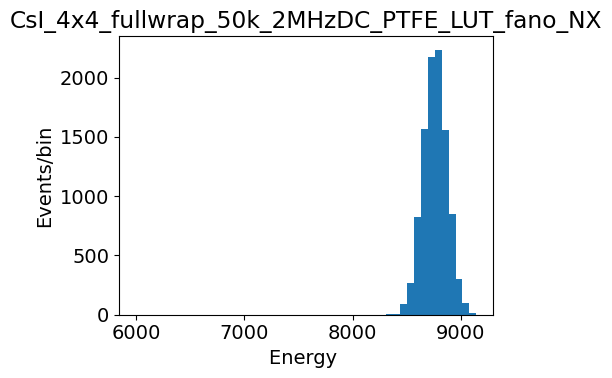

In [24]:
plot_energies2({"CsI_4x4_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=6000, xmax=max(energy),num_bins = 50)

In [25]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 8761.34 sigma = 1.26 % FWHM = 2.90 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [26]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [62]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=True)  # No comparison with energy only xyz


Running Monoataset with norm = False, resize=False, xyze=True
Loading files with indexes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
meta[1:-1] =[-17.736462   5.652053  14.491894]


In [63]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


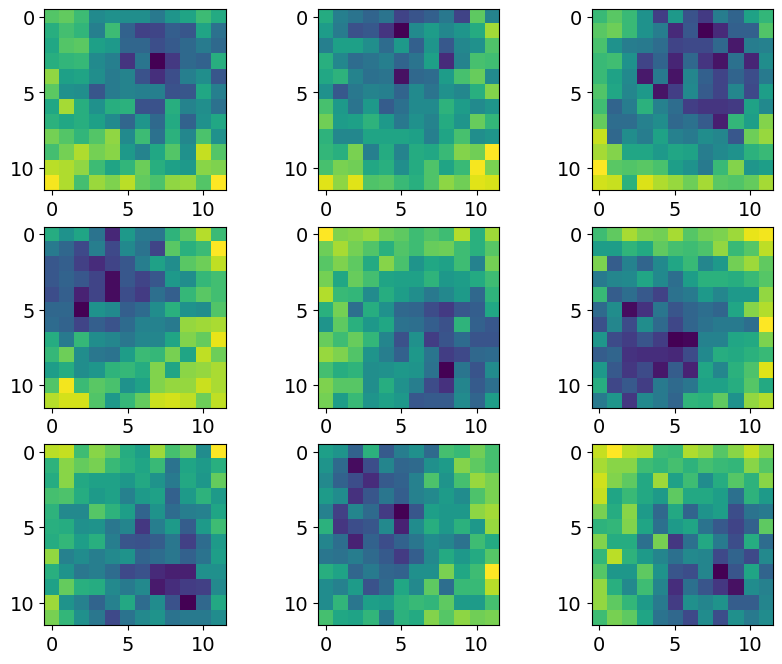

In [64]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [65]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 12, 12])
torch.Size([1000, 3])
tensor([[41., 49., 50., 53., 50., 59., 56., 48., 49., 65., 56., 45.],
        [49., 52., 49., 42., 52., 56., 49., 64., 73., 70., 56., 47.],
        [47., 35., 57., 76., 70., 67., 63., 63., 57., 66., 70., 47.],
        [47., 67., 48., 69., 64., 81., 69., 63., 64., 77., 56., 71.],
        [59., 54., 49., 65., 57., 70., 81., 71., 83., 50., 67., 51.],
        [52., 65., 75., 60., 72., 66., 76., 82., 71., 73., 57., 53.],
        [45., 40., 63., 75., 78., 61., 81., 61., 71., 67., 51., 76.],
        [41., 64., 61., 73., 71., 74., 92., 76., 89., 71., 65., 51.],
        [40., 50., 63., 69., 78., 78., 70., 63., 84., 71., 67., 64.],
        [52., 66., 61., 76., 66., 77., 73., 80., 63., 67., 73., 54.],
        [47., 68., 57., 60., 60., 62., 59., 65., 68., 68., 68., 51.],
        [49., 48., 42., 43., 61., 55., 49., 64., 49., 67., 62., 58.]])


### Define CNN

In [31]:
def image_shape_after_conv(I, P, K, S):
    """
    I: shape (1d) of input image
    P: Padding
    K: Kernel size
    S: stride
    """
    return ((I + 2*P - (K-1) -1)/S +1)
    

In [49]:
def image_evolution_cnn3x3(input, chi=64):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=2)
    conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
    conv5 = nn.Conv2d(chi*8, chi*16, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)
    i4 = doconv(i3, conv4, 4)
    i5 = doconv(i4, conv5, 5)

    print(f"shape of out image = {i5.shape}")
    

    


In [45]:
def image_evolution_cnn_basic(input, chi=128):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
    conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)
    i4 = doconv(i3, conv4, 3)

    print(f"shape of out image = {i4.shape}")

In [34]:
input = torch.randn(1, 1, 12, 12)  # batch = 1, channel=1, 12x12

In [50]:
image_evolution_cnn3x3(input, chi=64)

shape of input image = torch.Size([1, 1, 12, 12])
shape of image after convolution 1 = torch.Size([1, 64, 12, 12])
shape of image after pool 1= torch.Size([1, 64, 6, 6])
shape of image after convolution 2 = torch.Size([1, 128, 6, 6])
shape of image after pool 2= torch.Size([1, 128, 3, 3])
shape of image after convolution 3 = torch.Size([1, 256, 6, 6])
shape of image after pool 3= torch.Size([1, 256, 3, 3])
shape of image after convolution 4 = torch.Size([1, 512, 4, 4])
shape of image after pool 4= torch.Size([1, 512, 2, 2])
shape of image after convolution 5 = torch.Size([1, 1024, 3, 3])
shape of image after pool 5= torch.Size([1, 1024, 1, 1])
shape of out image = torch.Size([1, 1024, 1, 1])


In [46]:
image_evolution_cnn_basic(input, chi=128)

shape of input image = torch.Size([1, 1, 12, 12])
shape of image after convolution 1 = torch.Size([1, 128, 12, 12])
shape of image after pool 1= torch.Size([1, 128, 6, 6])
shape of image after convolution 2 = torch.Size([1, 256, 7, 7])
shape of image after pool 2= torch.Size([1, 256, 3, 3])
shape of image after convolution 3 = torch.Size([1, 512, 4, 4])
shape of image after pool 3= torch.Size([1, 512, 2, 2])
shape of image after convolution 3 = torch.Size([1, 1024, 3, 3])
shape of image after pool 3= torch.Size([1, 1024, 1, 1])
shape of out image = torch.Size([1, 1024, 1, 1])


In [48]:
class CNN_basic(nn.Module):
    """
    Defines a basic convolutional network with a basic architecture:
    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=128, dropout=False, dropout_fraction=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
        self.bn4   = nn.BatchNorm2d(chi*8)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc0 = nn.Linear(chi*8, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

 
    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
            
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        if(self.debug): print(f" after conv1 =>{x.shape}")
        
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        if(self.debug): print(f" after conv2 =>{x.shape}")
        
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        if(self.debug): print(f" after conv3 =>{x.shape}")

        x = self.pool(self.bn4(F.leaky_relu(self.conv4(x))))
        if(self.debug): print(f" after conv4 =>{x.shape}")
        
        x = x.flatten(start_dim=1)
        if(self.debug): print(f"(after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc0(x)    # linear layer 512 => 3 
        if(self.debug): print(f"(after linear =>{x.shape}")

        self.debug = False

        return x

In [55]:
class CNN_3x3(nn.Module):
    """
    Defines a convolutional network with a basic architecture:
    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=64, dropout=False, dropout_fraction=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=2)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
        self.bn4   = nn.BatchNorm2d(chi*8)
        self.conv5 = nn.Conv2d(chi*8, chi*16, 2, padding=1)
        self.bn5   = nn.BatchNorm2d(chi*16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc0 = nn.Linear(chi*16, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
        
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        if(self.debug): print(f" after conv1 =>{x.shape}")

        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        if(self.debug): print(f" after conv2 =>{x.shape}")
        
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        if(self.debug): print(f" after conv3 =>{x.shape}")
        
        x = self.pool(self.bn4(F.leaky_relu(self.conv4(x))))
        if(self.debug): print(f" after conv4 =>{x.shape}")

        x = self.pool(self.bn5(F.leaky_relu(self.conv5(x))))
        if(self.debug): print(f" after conv5 =>{x.shape}")
        
        x = x.flatten(start_dim=1)
        if(self.debug): print(f"(after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc0(x)    
        if(self.debug): print(f"(after linear =>{x.shape}")

        self.debug = False

        return x

In [56]:
# Load the model. Be careful to set energy to false if using conventional CNN (just positions)
model3x3 = CNN_3x3(dropout=False).to(device)  
print(model3x3)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=1024, out_features=3, bias=True)
  (

In [57]:
summary(model3x3,(1,12,12))

input data shape =>torch.Size([2, 1, 12, 12])
 after conv1 =>torch.Size([2, 64, 6, 6])
 after conv2 =>torch.Size([2, 128, 3, 3])
 after conv3 =>torch.Size([2, 256, 3, 3])
 after conv4 =>torch.Size([2, 512, 2, 2])
 after conv5 =>torch.Size([2, 1024, 1, 1])
(after flatten =>torch.Size([2, 1024])
(after linear =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 12, 12]             640
       BatchNorm2d-2           [-1, 64, 12, 12]             128
         MaxPool2d-3             [-1, 64, 6, 6]               0
            Conv2d-4            [-1, 128, 6, 6]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 256, 6, 6]         131,328
       BatchNorm2d-8            [-1, 256, 6, 6]             512
         MaxPool2d-9         

In [58]:
modelb = CNN_basic(dropout=False).to(device)  
print(modelb)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=1024, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [59]:
summary(modelb,(1,12,12))

input data shape =>torch.Size([2, 1, 12, 12])
 after conv1 =>torch.Size([2, 128, 6, 6])
 after conv2 =>torch.Size([2, 256, 3, 3])
 after conv3 =>torch.Size([2, 512, 2, 2])
 after conv4 =>torch.Size([2, 1024, 1, 1])
(after flatten =>torch.Size([2, 1024])
(after linear =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 12, 12]           1,280
       BatchNorm2d-2          [-1, 128, 12, 12]             256
         MaxPool2d-3            [-1, 128, 6, 6]               0
            Conv2d-4            [-1, 256, 7, 7]         131,328
       BatchNorm2d-5            [-1, 256, 7, 7]             512
         MaxPool2d-6            [-1, 256, 3, 3]               0
            Conv2d-7            [-1, 512, 4, 4]         524,800
       BatchNorm2d-8            [-1, 512, 4, 4]           1,024
         MaxPool2d-9            [-1, 512, 2, 2]               0
      

In [60]:
# Set up the optimizer and loss function.
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)
optimizerb = optim.Adam(modelb.parameters(), lr=0.001)
criterion = nn.MSELoss()


## Cnn3x3

In [66]:
single_run(train_loader, device, model3x3, optimizer3x3,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 12, 12])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 200.64724731445312
i = 1
images = torch.Size([1000, 1, 12, 12])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 91.65751647949219


## Draft result (partial stats, no drop out, no norm)

In [67]:
epochs = 10

In [68]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 200/210, Loss: 4.967139720916748
--- EPOCH 0 AVG TRAIN LOSS: 5.75620683715457
--- EPOCH 0 AVG VAL LOSS: 5.174516622225443

EPOCH 1
Train Step 200/210, Loss: 4.327873706817627
--- EPOCH 1 AVG TRAIN LOSS: 4.569890693255833
--- EPOCH 1 AVG VAL LOSS: 4.6100870291392

EPOCH 2
Train Step 200/210, Loss: 4.15791130065918
--- EPOCH 2 AVG TRAIN LOSS: 4.359453152474903
--- EPOCH 2 AVG VAL LOSS: 4.870531749725342

EPOCH 3
Train Step 200/210, Loss: 4.1056013107299805
--- EPOCH 3 AVG TRAIN LOSS: 4.26575707821619
--- EPOCH 3 AVG VAL LOSS: 4.485844580332438

EPOCH 4
Train Step 200/210, Loss: 4.014225482940674
--- EPOCH 4 AVG TRAIN LOSS: 4.17739767801194
--- EPOCH 4 AVG VAL LOSS: 4.410385282834371

EPOCH 5
Train Step 200/210, Loss: 4.060541152954102
--- EPOCH 5 AVG TRAIN LOSS: 4.185907476288932
--- EPOCH 5 AVG VAL LOSS: 4.24308554

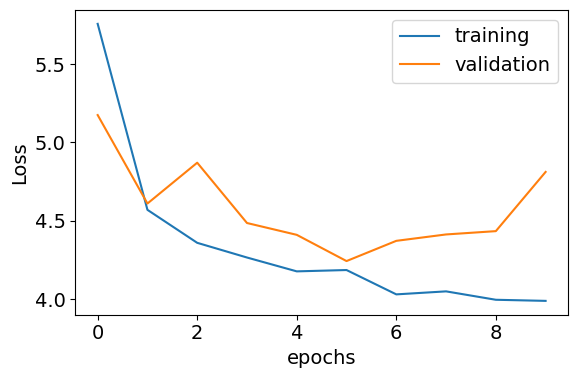

In [69]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [70]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, energy=False)

In [54]:
#plot_true_predicted(tdeltas, nbins = 50)

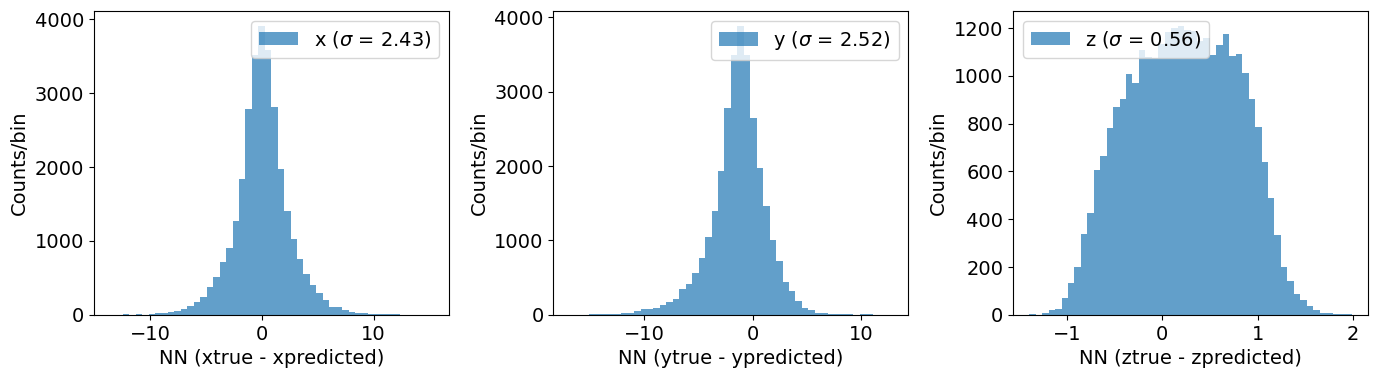

In [71]:
plotxyz(tdeltas, nbins=50)

In [42]:
#plotxyze(tdeltas, nbins=50)

## Normalization

In [72]:
means, stds = get_means_stds(dir=crystal)

files in dir: 100
shape -> (10000, 12, 12)
mean img0 =61.65277862548828
std  img0 =13.507878303527832


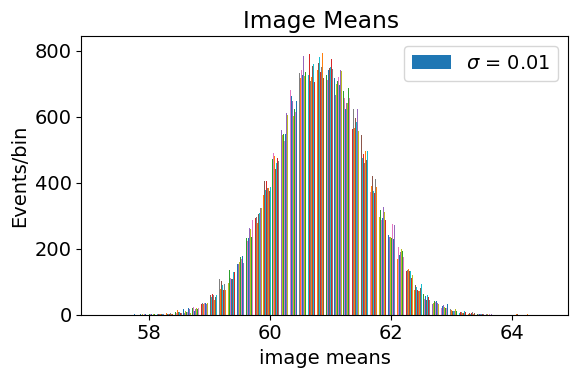

In [73]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

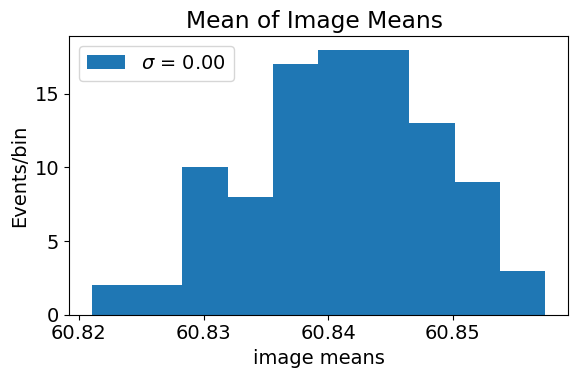

In [74]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [75]:
imean = np.mean(meansx)

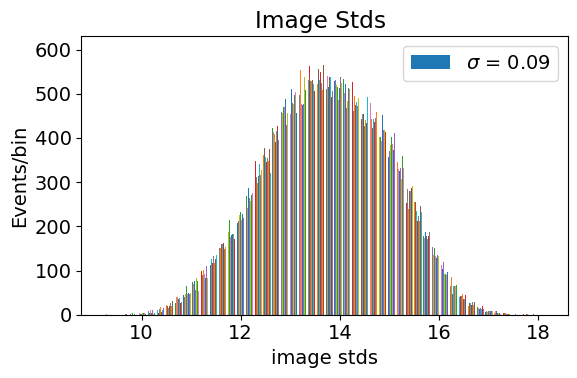

In [76]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

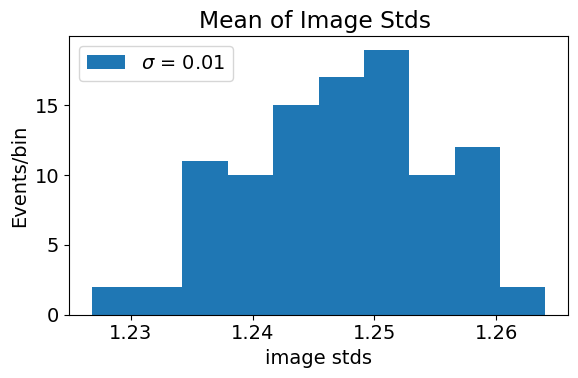

In [77]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [78]:
isigma = np.mean(stdsx)

In [79]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 60.841224670410156, std = 1.247104287147522


### Run with full stats and normalization 

In [64]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [80]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=True)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=True
Loading files with indexes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
meta[1:-1] =[-17.736462   5.652053  14.491894]


In [81]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


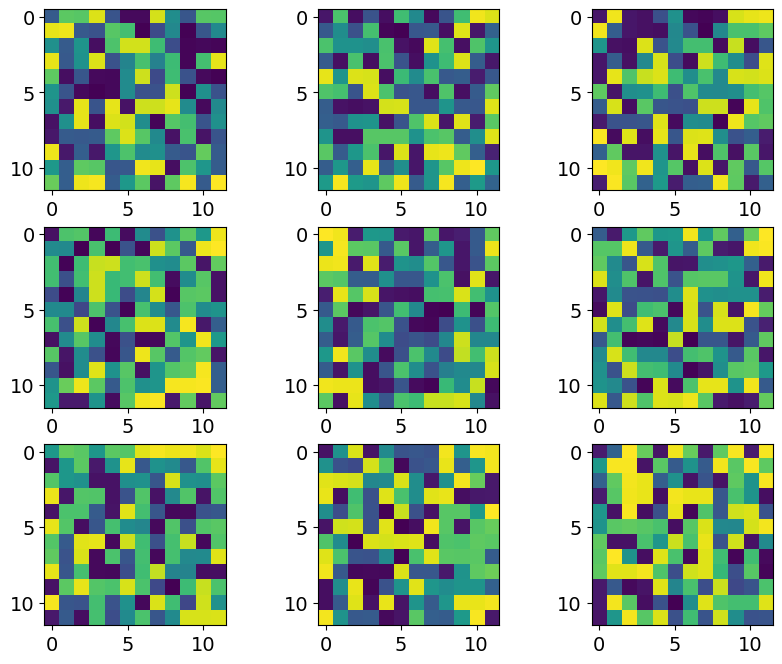

In [82]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [83]:
model3x3 = CNN_3x3(dropout=False).to(device)
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)

In [84]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=10, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 12, 12])
 after conv1 =>torch.Size([1000, 64, 6, 6])
 after conv2 =>torch.Size([1000, 128, 3, 3])
 after conv3 =>torch.Size([1000, 256, 3, 3])
 after conv4 =>torch.Size([1000, 512, 2, 2])
 after conv5 =>torch.Size([1000, 1024, 1, 1])
(after flatten =>torch.Size([1000, 1024])
(after linear =>torch.Size([1000, 3])
Train Step 200/210, Loss: 4.764046669006348
--- EPOCH 0 AVG TRAIN LOSS: 6.8042922224317275
--- EPOCH 0 AVG VAL LOSS: 5.0773716767628985

EPOCH 1
Train Step 200/210, Loss: 4.260648250579834
--- EPOCH 1 AVG TRAIN LOSS: 4.465354556129093
--- EPOCH 1 AVG VAL LOSS: 4.8760725100835165

EPOCH 2
Train Step 200/210, Loss: 4.410714626312256
--- EPOCH 2 AVG TRAIN LOSS: 4.328033788998922
--- EPOCH 2 AVG VAL LOSS: 4.949123462041219

EPOCH 3
Train Step 200/210, Loss: 4.009796619415283
--- EP

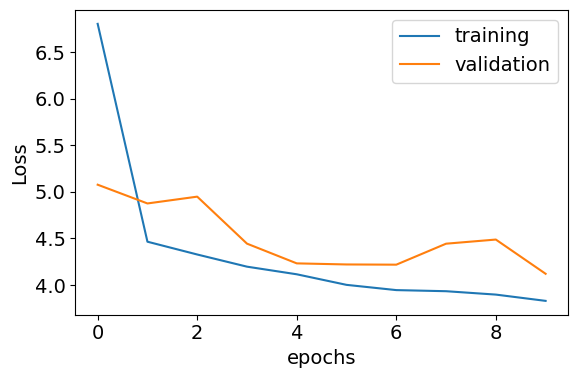

In [85]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [86]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, pixel_size = 6, energy=False)


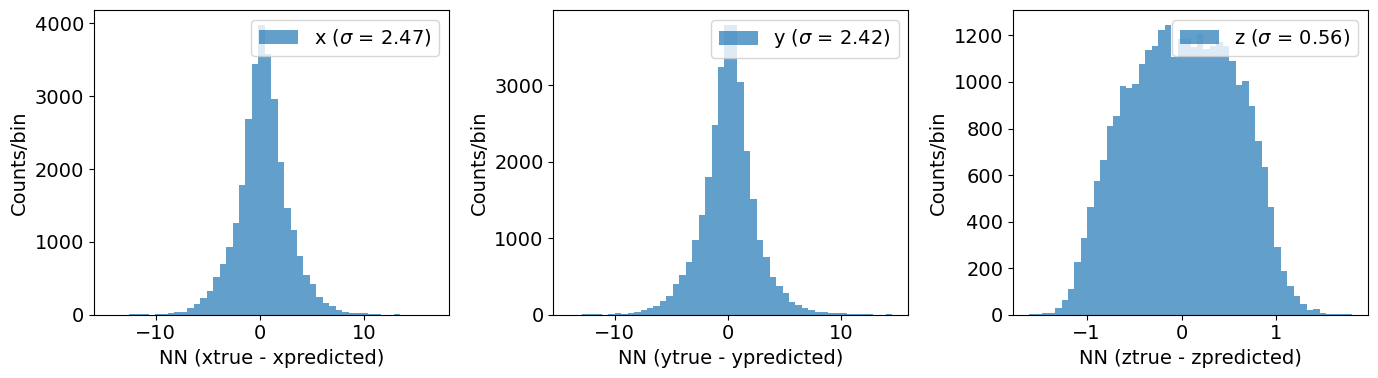

In [87]:
plotxyz(tdeltas, nbins=50)

## Repeat with dropout

In [89]:
model3x3 = CNN_3x3(dropout=True).to(device)
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)

In [90]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=20, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 12, 12])
 after conv1 =>torch.Size([1000, 64, 6, 6])
 after conv2 =>torch.Size([1000, 128, 3, 3])
 after conv3 =>torch.Size([1000, 256, 3, 3])
 after conv4 =>torch.Size([1000, 512, 2, 2])
 after conv5 =>torch.Size([1000, 1024, 1, 1])
(after flatten =>torch.Size([1000, 1024])
(after linear =>torch.Size([1000, 3])
Train Step 200/210, Loss: 4.683096885681152
--- EPOCH 0 AVG TRAIN LOSS: 7.213267732801891
--- EPOCH 0 AVG VAL LOSS: 4.50351897875468

EPOCH 1
Train Step 200/210, Loss: 4.390921592712402
--- EPOCH 1 AVG TRAIN LOSS: 4.788443733396984
--- EPOCH 1 AVG VAL LOSS: 4.467536727587382

EPOCH 2
Train Step 200/210, Loss: 4.359724998474121
--- EPOCH 2 AVG TRAIN LOSS: 4.481490442866371
--- EPOCH 2 AVG VAL LOSS: 5.259669542312622

EPOCH 3
Train Step 200/210, Loss: 4.038611888885498
--- EPOCH 

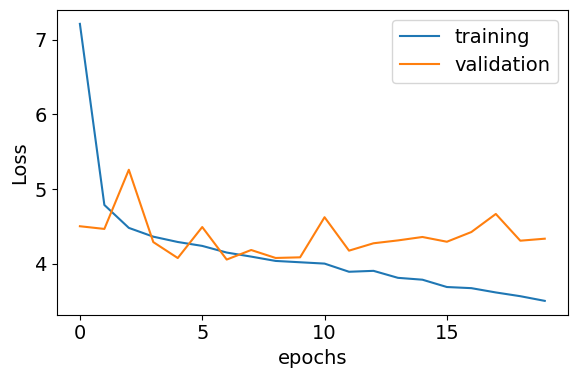

In [92]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [93]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, pixel_size = 6, energy=False)


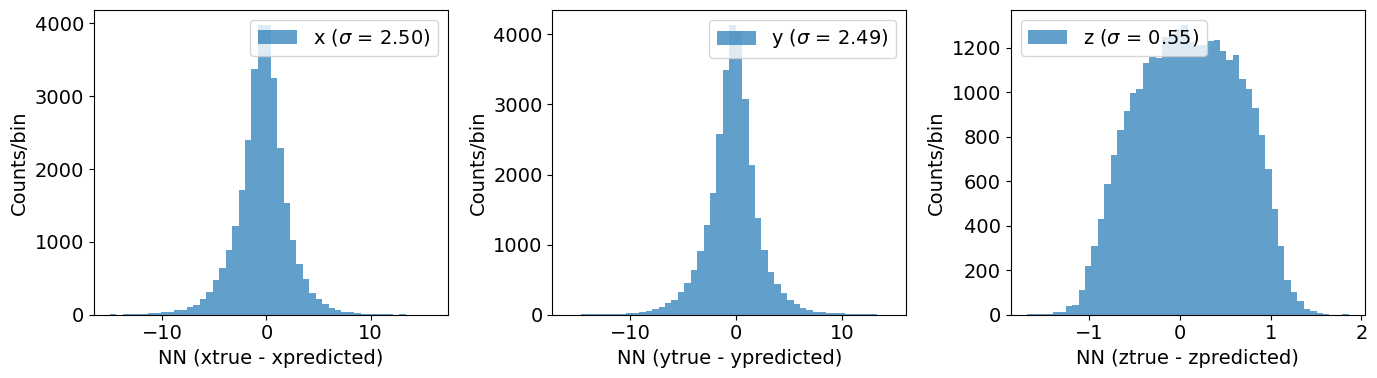

In [94]:
plotxyz(tdeltas, nbins=50)

## Basic network

In [96]:
modelb = CNN_basic(dropout=True).to(device)  
optimizerb = optim.Adam(modelb.parameters(), lr=0.001)

In [97]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelb, optimizerb, device, criterion, 
                                    batch_size, epochs=20, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 12, 12])
 after conv1 =>torch.Size([1000, 128, 6, 6])
 after conv2 =>torch.Size([1000, 256, 3, 3])
 after conv3 =>torch.Size([1000, 512, 2, 2])
 after conv4 =>torch.Size([1000, 1024, 1, 1])
(after flatten =>torch.Size([1000, 1024])
(after linear =>torch.Size([1000, 3])
Train Step 200/210, Loss: 4.986038684844971
--- EPOCH 0 AVG TRAIN LOSS: 7.21687989689055
--- EPOCH 0 AVG VAL LOSS: 4.7189134438832605

EPOCH 1
Train Step 200/210, Loss: 4.9932780265808105
--- EPOCH 1 AVG TRAIN LOSS: 4.932565191813878
--- EPOCH 1 AVG VAL LOSS: 4.93719630241394

EPOCH 2
Train Step 200/210, Loss: 4.365505695343018
--- EPOCH 2 AVG TRAIN LOSS: 4.655983071100144
--- EPOCH 2 AVG VAL LOSS: 4.645855681101481

EPOCH 3
Train Step 200/210, Loss: 4.51972770690918
--- EPOCH 3 AVG TRAIN LOSS: 4.4929773739406045
--- EPO

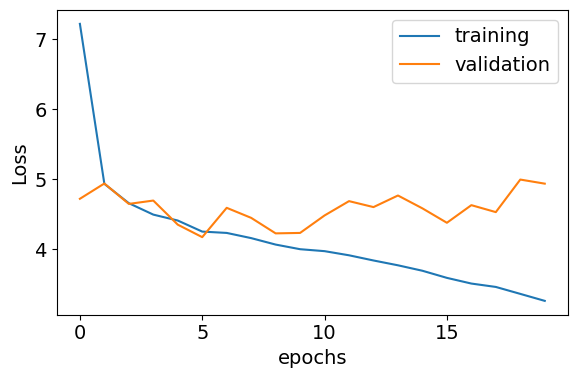

In [99]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [100]:
tdeltas = evaluate_cnn(test_loader, modelb, device, pixel_size = 6, energy=False)

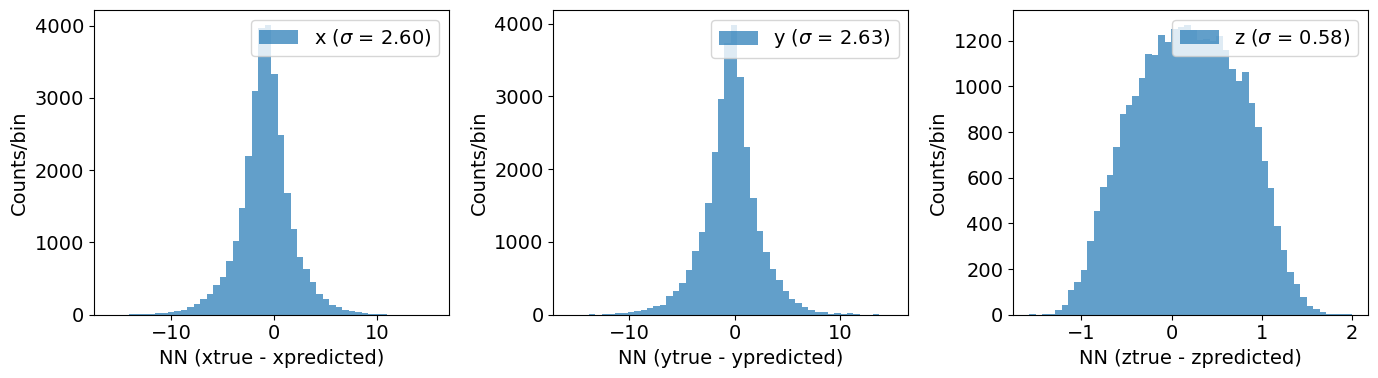

In [101]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [104]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [110]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.pool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [119]:
#define the model
modelrn = ResNet10(ResBlock, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [120]:
summary(modelrn,(1,12,12))

 ResNet10: input data shape =>torch.Size([2, 1, 12, 12])
 ResNet10: after conv1 =>torch.Size([2, 64, 12, 12])
 ResNet10: after layer0 =>torch.Size([2, 64, 12, 12])
 ResNet10: after layer1 =>torch.Size([2, 128, 6, 6])
 ResNet10: after layer2 =>torch.Size([2, 256, 3, 3])
 ResNet10: after layer3 =>torch.Size([2, 512, 2, 2])
 ResNet10: after avgpool =>torch.Size([2, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([2, 512])
 ResNet10: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 12, 12]             640
       BatchNorm2d-2           [-1, 64, 12, 12]             128
              ReLU-3           [-1, 64, 12, 12]               0
            Conv2d-4           [-1, 64, 12, 12]          36,928
       BatchNorm2d-5           [-1, 64, 12, 12]             128
              ReLU-6           [-1, 64, 12, 12]               0
            Conv2d-7 

In [121]:
optimizerrn = optim.Adam(modelrn.parameters(), lr=0.001)

In [122]:
single_run(train_loader, device, modelrn, optimizerrn,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 12, 12])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 171.47593688964844
i = 1
images = torch.Size([1000, 1, 12, 12])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 81.3196029663086


In [123]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelrn, optimizerrn, device, criterion, 
                                    batch_size=500, epochs=20, iprnt=200)

Training with  ->105000 images
size of train loader  ->210 images
Evaluating with  ->30000 images
size of eval loader  ->60 images
Running for epochs ->20

EPOCH 0
Train Step 200/210, Loss: 4.734848976135254
--- EPOCH 0 AVG TRAIN LOSS: 6.240300478254046
--- EPOCH 0 AVG VAL LOSS: 5.428420861562093

EPOCH 1
Train Step 200/210, Loss: 4.764682292938232
--- EPOCH 1 AVG TRAIN LOSS: 4.9138113793872655
--- EPOCH 1 AVG VAL LOSS: 4.116262813409169

EPOCH 2
Train Step 200/210, Loss: 4.433588027954102
--- EPOCH 2 AVG TRAIN LOSS: 4.614019269034976
--- EPOCH 2 AVG VAL LOSS: 4.569694447517395

EPOCH 3
Train Step 200/210, Loss: 5.297973155975342
--- EPOCH 3 AVG TRAIN LOSS: 4.497415658405849
--- EPOCH 3 AVG VAL LOSS: 4.581821163495381

EPOCH 4
Train Step 200/210, Loss: 4.862000465393066
--- EPOCH 4 AVG TRAIN LOSS: 4.4339207138334
--- EPOCH 4 AVG VAL LOSS: 4.178586582342784

EPOCH 5
Train Step 200/210, Loss: 4.1794257164001465
--- EPOCH 5 AVG TRAIN LOSS: 4.363259737832205
--- EPOCH 5 AVG VAL LOSS: 4.027

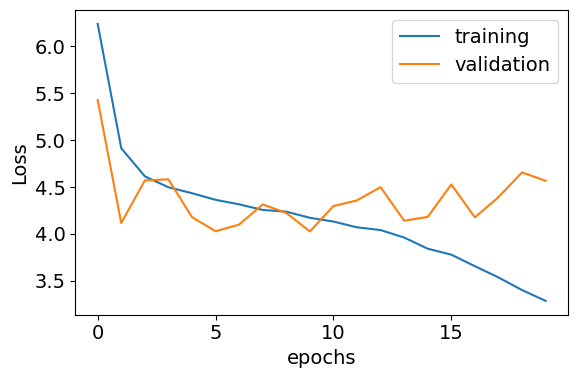

In [124]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))



In [125]:
tdeltas = evaluate_cnn(test_loader, modelrn, device, pixel_size = 6, energy=False)

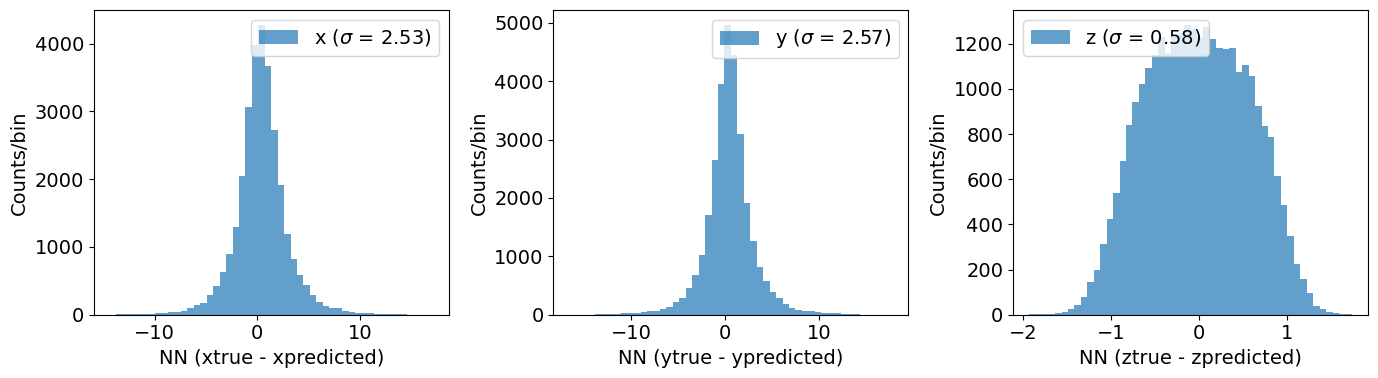

In [126]:
plotxyz(tdeltas, nbins=50)

## Fit data

In [127]:
def bin_centers(bins):
    return np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
def weighted_error(sigma1, w1, sigma2, w2):
    return sigma1 * w1 + sigma2 * w2

In [128]:
def fit_dgaussian(xdata, 
                  ydata, 
                  pars=[10000., 0.5, 2.0, 10000., 0.5, 2.0],
                  lower_bounds = [0, -1.0, 0.0, 0.0, -1.0, 0.0],
                  upper_bounds = [100000, 1.0, 15.0, 100000.0, 1.0, 15.0]
                 ):

    def gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
        g1 = a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
        g2 = a2*(np.exp(-(x-mu2)**2/(2*sigma2**2)))
        return g1 + g2
    
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars, 
                          bounds=(lower_bounds, upper_bounds))
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 

In [129]:
def fit_coord(tdeltas, bins=100):
    def bin_data(data, bins):
        hdz, binsz = np.histogram(data, bins=bins)
        xdata = bin_centers(binsz)
        ydata = hdz
        return xdata, ydata

    def fitcoord2g(data, bins):
        xdata, ydata = bin_data(data, bins)
        pars, err, yfit = fit_dgaussian(xdata, ydata)
        n1 = pars[0]/(pars[0]+ pars[3])
        n2 = pars[3]/(pars[0]+ pars[3])
        we = weighted_error(pars[2], n1, pars[5], n2)
        print(f"2g fit: mu1 = {pars[1]:.2f}, sigma = {pars[2]:.2f}, n1  ={n1:.2f}")
        print(f"2g fit: mu2 = {pars[4]:.2f}, sigma = {pars[5]:.2f}, n1  ={n2:.2f}")
        print(f"weighted error: = {we:.2f}")
    
        fit2g = namedtuple('fit2g',
               'xdata, ydata, yfit, norms, mus, sigmas')
        return fit2g(xdata, ydata, yfit, 
                    (pars[0], pars[3]), (pars[1], pars[4]), (pars[2], pars[5]))
        
    f2gz = fitcoord2g(tdeltas.delta_z_NN, bins=bins)
    f2gx = fitcoord2g(tdeltas.delta_x_NN, bins=bins)
    f2gy = fitcoord2g(tdeltas.delta_y_NN, bins=bins)
    
    return f2gz, f2gx, f2gy

In [130]:
def plotfxyz(f2gx, f2gy, f2gz, figsize=(8, 6)):
    def n1n2(norms):
        n1 = norms[0]/(norms[0]+ norms[1])
        n2 = norms[1]/(norms[0]+ norms[1])
        return n1, n2
        
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    flat_axes = axes.ravel()
    ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

    n1, n2 = n1n2(f2gx.norms)
    ax0.errorbar(f2gx.xdata, f2gx.ydata,yerr=np.sqrt(f2gx.ydata), fmt='o', markersize=2)
    ax0.plot(f2gx.xdata, f2gx.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gx.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gx.sigmas[1]:.2f}")
    ax0.legend()
    ax0.set_xlabel("NN (xtrue - xpredicted)",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    
    n1, n2 = n1n2(f2gy.norms)
    ax1.errorbar(f2gy.xdata, f2gy.ydata,yerr=np.sqrt(f2gy.ydata), fmt='o', markersize=2)
    ax1.plot(f2gy.xdata, f2gy.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gy.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gy.sigmas[1]:.2f}")
    ax1.legend()
    ax1.set_xlabel("NN (ytrue - ypredicted)",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)

    n1, n2 = n1n2(f2gz.norms)
    ax2.errorbar(f2gz.xdata, f2gz.ydata,yerr=np.sqrt(f2gz.ydata), fmt='o', markersize=2)
    ax2.plot(f2gz.xdata, f2gz.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gz.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gz.sigmas[1]:.2f}")
    ax2.legend()
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)

    fig.tight_layout()
    plt.show()

In [131]:
tdeltas

tdeltas(delta_x_NN=array([-1.5153961 ,  1.6464205 ,  1.028836  , ..., -0.82748795,
       -0.5035572 , -0.1999054 ], dtype=float32), delta_y_NN=array([-5.6372576 , -0.14541698, -0.5282078 , ...,  0.30648756,
        1.7774224 ,  1.4294548 ], dtype=float32), delta_z_NN=array([ 0.3143854 , -1.002285  ,  0.87134933, ...,  0.51111794,
        0.37787628, -0.37285233], dtype=float32), delta_x_classical=0.0, delta_y_classical=0.0)

In [132]:
f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)

2g fit: mu1 = -0.01, sigma = 0.66, n1  =0.50
2g fit: mu2 = -0.02, sigma = 0.66, n1  =0.50
weighted error: = 0.66
2g fit: mu1 = 0.29, sigma = 1.19, n1  =0.68
2g fit: mu2 = 0.43, sigma = 2.91, n1  =0.32
weighted error: = 1.73
2g fit: mu1 = 0.35, sigma = 1.08, n1  =0.68
2g fit: mu2 = 0.43, sigma = 2.83, n1  =0.32
weighted error: = 1.63


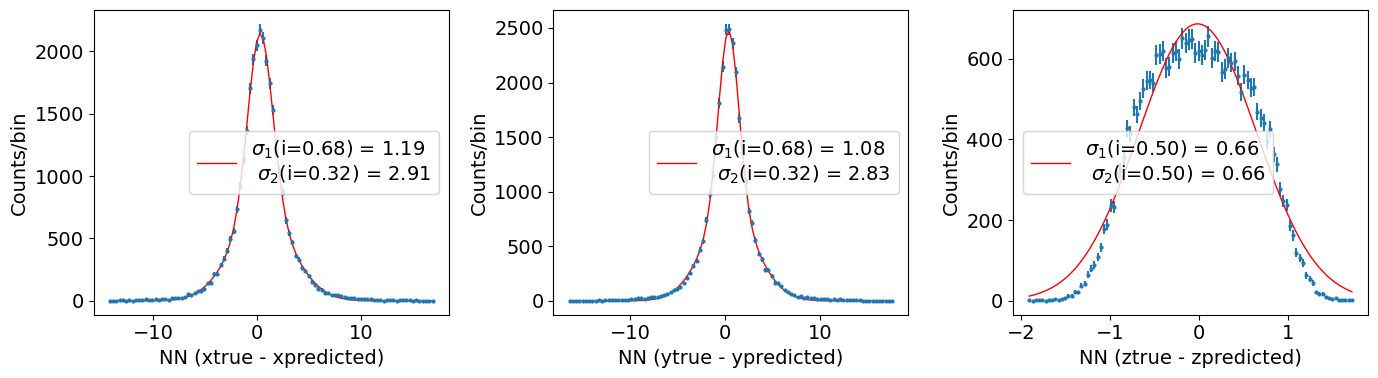

In [133]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))